In [1]:
%load_ext autoreload

In [94]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
from neural_analysis import spectra
import sys

sys.path.append('..')
from utils import *
from nld_utils import *

In [96]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
dt = get_sample_interval(f, 's')
fs = 1/dt
lfp_areas = [to_string(item, f) for item in f['electrodeInfo']['area'][0]]
airPuff_binary, audio_binary = get_binary_stimuli(f)

## Basic Sin Wave

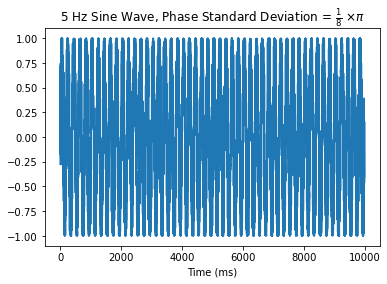

In [90]:
freq = 5 # Hz
duration = 10 # s
length = int(duration*fs)

# construct sin wave
sin_wave = np.zeros(length)
phase_sd = np.pi/8
for t in range(length):
    phase = np.random.randn()*phase_sd
    sin_wave[t] = np.sin(2*np.pi*t*dt*freq + phase)
plt.plot(sin_wave)
plt.xlabel("Time (ms)")
integer_ratio = (phase_sd/np.pi).as_integer_ratio()
plt.title(fr"{freq} Hz Sine Wave, Phase Standard Deviation = " + r"$\frac{%d}{%d}$" % integer_ratio + r" $\times \pi$")
plt.show()

In [91]:
signal_in = sin_wave

p = 1
r = 10
theiler_window = 10
maxt = 300

ret = lyapunov_analysis(signal_in, tau=45, nlags=min(int(len(signal_in)/2), 1000), max_m=10, p=p, r=r, theiler_window=theiler_window, maxt=maxt)

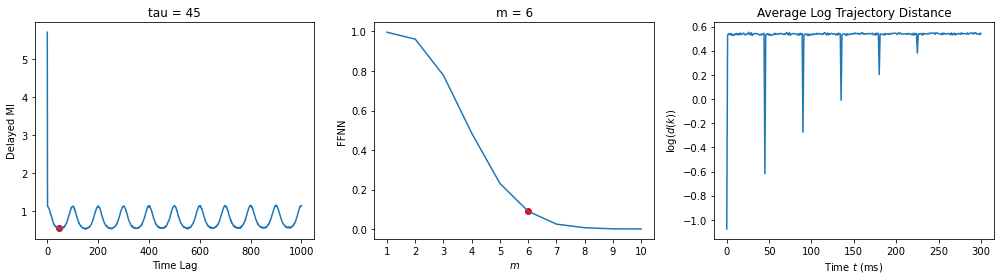

In [92]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(ret['delayed_mi'])
plt.title(f"tau = {ret['tau']}")
plt.scatter(ret['tau'], ret['delayed_mi'][ret['tau']], c='red')
plt.xlabel(r'Time Lag')
plt.ylabel(r'Delayed MI')

plt.subplot(1, 3, 2)
plt.plot(ret['m_vals'], ret['fraction_fnn'])
plt.title(f"m = {ret['m']}")
plt.scatter(ret['m'], ret['fraction_fnn'][ret['m'] - 1], c='red')
plt.xticks(ret['m_vals'], ret['m_vals'])
plt.xlabel(r'$m$')
plt.ylabel(r'FFNN')

plt.subplot(1, 3, 3)
ret['t'] = np.arange(len(ret['d']))
plt.plot(ret['t'], ret['d'])
plt.title(f"Average Log Trajectory Distance")
plt.xlabel(r'Time $t$ (ms)')
plt.ylabel(r'log($d(k)$)')

plt.tight_layout()
plt.show()

# Whole Trial Power Spectra

In [210]:
# ==============
# INPUTS
# ==============

# LFP ARGS

unit_index = 0
duration = 40 # s
# trajectory_start_times = np.arange(0, 7001, 500) # s
trajectory_start_times = [int(val) for val in np.arange(0, f['lfp'].shape[1]*dt - duration, duration)]

# SPECTROGRAM ARGS

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=0.25,
    freq_width=4,
    spacing=0.01,
    freq_range=[0, 80],
)

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

#  NLD ARGS

p = 1
r = 10
theiler_window = 60 # ms
maxt = 300

# ========
trajectory_start_steps = np.int0(trajectory_start_times/dt)
length = int(duration/dt)

results_pow = {}
for band in bands:
    results_pow[band] = []

    
iterator = tqdm(total=len(trajectory_start_steps)*len(bands)) 
for start_step in trajectory_start_steps: 
    lfp_signal = f['lfp'][unit_index, start_step:start_step + length]
    spec, freq, timepts = spectra.spectrogram(lfp_signal, fs, **spectrogram_kwargs)
    freq_band_power = dict(
        delta=spec[np.logical_and(freq > 0, freq <= 4)].sum(0),
        theta=spec[np.logical_and(freq > 4, freq <= 8)].sum(0),
        alpha=spec[np.logical_and(freq > 8, freq <= 12)].sum(0),
        beta=spec[np.logical_and(freq > 12, freq <= 30)].sum(0),
        gamma=spec[np.logical_and(freq > 30, freq <= 80)].sum(0),
    )
    for band in bands:
        signal_in = freq_band_power[band]
        ret = lyapunov_analysis(signal_in, nlags=min(1000, int(len(signal_in)/2)), max_m=10, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
        ret['signal'] = signal_in
        ret['airPuff'] = [airPuff_binary[start_step + int(timepts[i]*fs):start_step + int(timepts[i]*fs) + int(spectrogram_kwargs['time_width']*fs)].sum() > 0 for i in np.arange(len(timepts))]
        ret['audio'] = [audio_binary[start_step + int(timepts[i]*fs):start_step + int(timepts[i]*fs) + int(spectrogram_kwargs['time_width']*fs)].sum() > 0 for i in np.arange(len(timepts))]
        ret['start_step'] = start_step
        ret['band'] = band
        ret['freq_band_power'] = freq_band_power
    
        results_pow[band].append(ret)
    
        iterator.update()
iterator.close()

In [140]:
num_local_mins = 2
local_min_locs = {}
for band in results_pow.keys():
    local_min_locs[band] = np.zeros((len(results_pow[band]), num_local_mins))
    for i, ret in enumerate(results_pow[band]):
        local_min_locs[band][i] = argrelextrema(ret['d'], np.less)[0][:num_local_mins]*spectrogram_kwargs['spacing']*fs

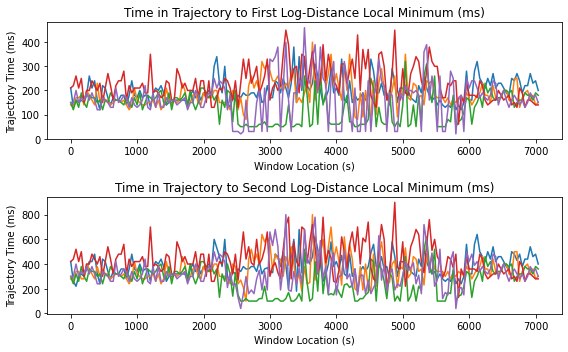

In [151]:
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
for band in bands:
    plt.plot(np.arange(local_min_locs[band].shape[0])*duration, local_min_locs[band][:, 0], label=band)
plt.title('Time in Trajectory to First Log-Distance Local Minimum (ms)')
plt.ylabel('Trajectory Time (ms)')
plt.xlabel('Window Location (s)')

plt.subplot(2, 1, 2)
for band in bands:
    plt.plot(np.arange(local_min_locs[band].shape[0])*duration, local_min_locs[band][:, 1], label=band)
plt.title('Time in Trajectory to Second Log-Distance Local Minimum (ms)')
plt.ylabel('Trajectory Time (ms)')
plt.xlabel('Window Location (s)')

plt.tight_layout()
plt.show()

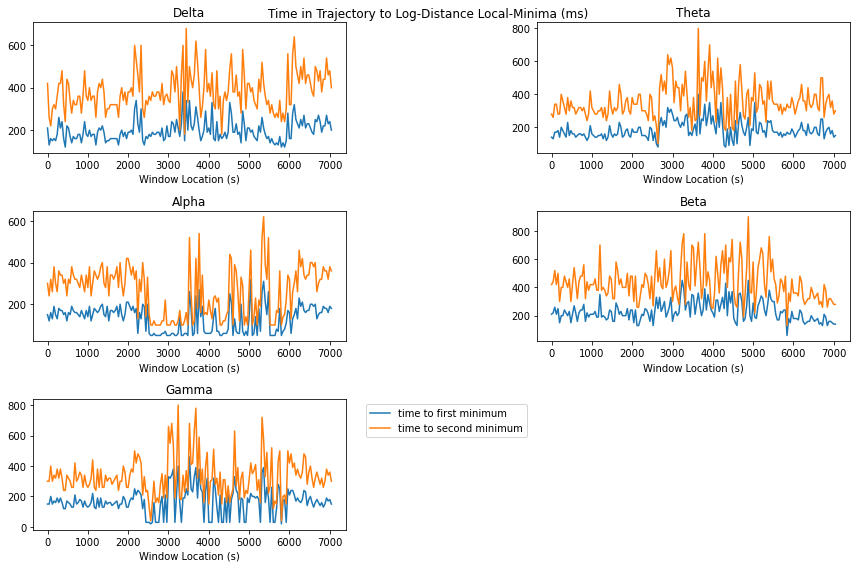

In [168]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=0.8)
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

for i, band in enumerate(bands):
    plt.subplot(3, 2, i + 1)
    plt.plot(np.arange(local_min_locs[band].shape[0])*duration, local_min_locs[band][:, 0], label='time to first minimum')
    plt.plot(np.arange(local_min_locs[band].shape[0])*duration, local_min_locs[band][:, 1], label='time to second minimum')
    plt.title(band.capitalize())
    plt.xlabel('Window Location (s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Time in Trajectory to Log-Distance Local-Minima (ms)')
plt.tight_layout()
plt.show()

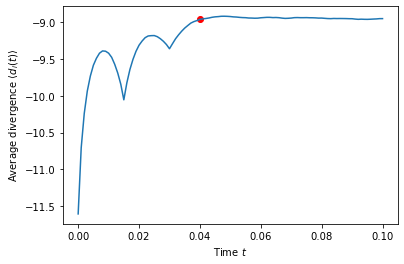

In [180]:
plt.scatter(sat_ind*dt, ret['d'][sat_ind], c='red')
plt.plot(ret['t']*dt, ret['d'])
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.show()

In [205]:
converged_length = 20 # indices
thresh=0.01

time_to_saturation = {}
for band in results_pow.keys():
    time_to_saturation[band] = np.zeros(len(results_pow[band]))
    for i, ret in enumerate(results_pow[band]):
        sat_ind = np.argmax(np.abs(ret['d'] - ret['d'][-converged_length:].mean()) < thresh)
#         if sat_ind == 0:
#             sat_ind = len(ret['d']) - 1
        time_to_saturation[band][i] = sat_ind*spectrogram_kwargs['spacing']*fs

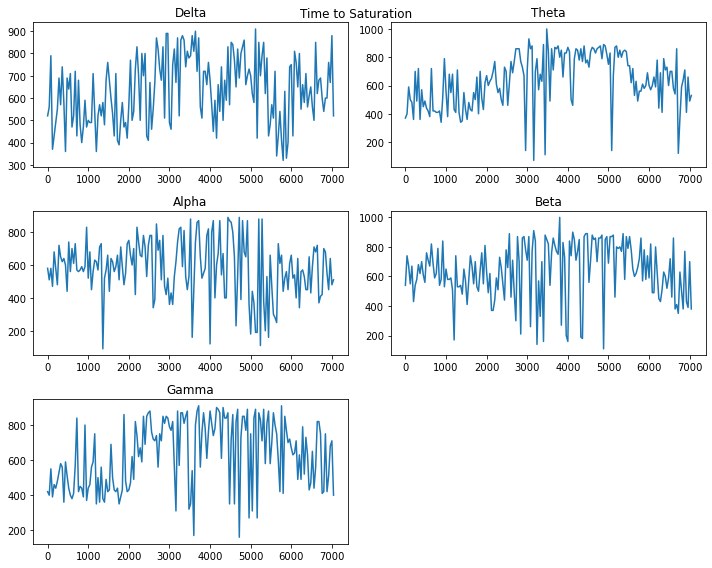

In [202]:
plt.figure(figsize=(10, 8))
i = 1
for band in time_to_saturation.keys():
    plt.subplot(3, 2, i)
    plt.plot(np.arange(len(time_to_saturation[band]))*duration, time_to_saturation[band])
    plt.title(band.capitalize())
    i += 1
plt.tight_layout()
plt.suptitle("Time to Saturation")
plt.show()

In [203]:
min_ind = time_to_saturation['beta'].argmin()

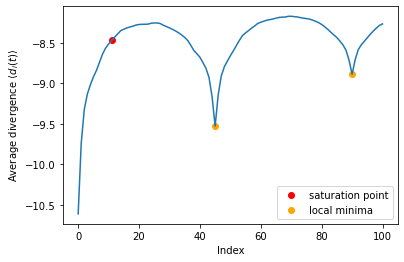

In [209]:
ret = results_pow['beta'][min_ind]
plt.plot(ret['d'])
sat_ind = np.argmax(np.abs(ret['d'] - ret['d'][-converged_length:].mean()) < thresh)
plt.scatter(sat_ind, ret['d'][sat_ind], c='red', label='saturation point')
local_min_locs = argrelextrema(ret['d'], np.less)[0][:2]
plt.scatter(local_min_locs, ret['d'][local_min_locs], c='orange', label='local minima')
plt.xlabel(r'Index')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.legend()
plt.show()